<h1>Project 1</h1>
<hr>
<h2>Road Traffic Severity Classification</h2>
This data set is collected from Addis Ababa Sub-city police departments for master's research work. The data set has been prepared from manual records of road traffic accidents of the year 2017-20. All the sensitive information has been excluded during data encoding and finally it has 32 features and 12316 instances of the accident. Then it is preprocessed and for identification of major causes of the accident by analyzing it using different machine learning classification algorithms.

<hr>
<h2>Modeling</h2>
<hr>


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
#from autoviz.AutoViz_Class import AutoViz_Class
#from autoviz import data_cleaning_suggestions
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import f1_score
from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            recall_score, precision_score,
                            confusion_matrix
                            )
from sklearn.model_selection import GridSearchCV
from mlxtend.evaluate import mcnemar_table, mcnemar_tables
from mlxtend.plotting import checkerboard_plot, plot_decision_regions
from collections import Counter
from imblearn.over_sampling import SMOTE
#import missingno as msno
%matplotlib inline      
import seaborn as sns
import numpy as np
import joblib
import pickle

In [2]:
df=pd.read_csv('../datasets/RTA Dataset_encoded.csv')

In [3]:
df.head()

,Unnamed: 0,number_of_vehicles_involved,number_of_casualties,accident_severity,time_hours,day_of_week_encoded,driving_experience_encoded,educational_level_encoded,age_band_of_casualty_encoded,service_year_of_vehicle_encoded,...,weather_conditions_encoded,types_of_junction_encoded,lanes_or_medians_encoded,road_surface_type_encoded,owner_of_vehicle_encoded,road_surface_conditions_encoded,casualty_class_encoded,light_conditions_encoded,sex_of_casualty_encoded,sex_of_driver_encoded
0,0,2,2,Slight Injury,17,1,0,0,5,3,...,2,1,5,0,3,0,3,3,2,1
1,1,2,2,Slight Injury,17,1,3,4,5,2,...,2,1,4,0,3,0,3,3,2,1
2,2,2,2,Serious Injury,17,1,0,4,1,5,...,2,1,6,0,3,0,0,3,1,1
3,3,2,2,Slight Injury,1,3,2,4,0,5,...,2,7,6,2,0,0,2,0,0,1
4,4,2,2,Slight Injury,1,3,1,4,5,2,...,2,7,6,0,3,0,3,0,2,1


In [4]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
#select All features, except the target variable
labels = df.columns.to_list()
labels.remove('accident_severity')
labels

['number_of_vehicles_involved',
 'number_of_casualties',
 'time_hours',
 'day_of_week_encoded',
 'driving_experience_encoded',
 'educational_level_encoded',
 'age_band_of_casualty_encoded',
 'service_year_of_vehicle_encoded',
 'age_band_of_driver_encoded',
 'casualty_severity_encoded',
 'cause_of_accident_encoded',
 'type_of_vehicle_encoded',
 'area_accident_occured_encoded',
 'vehicle_movement_encoded',
 'road_allignment_encoded',
 'type_of_collision_encoded',
 'pedestrian_movement_encoded',
 'weather_conditions_encoded',
 'types_of_junction_encoded',
 'lanes_or_medians_encoded',
 'road_surface_type_encoded',
 'owner_of_vehicle_encoded',
 'road_surface_conditions_encoded',
 'casualty_class_encoded',
 'light_conditions_encoded',
 'sex_of_casualty_encoded',
 'sex_of_driver_encoded']

In [6]:
#Create datasets X and y
X = df[labels]
y = df['accident_severity']

In [7]:
#create datasets to train and test the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [8]:
#Upsamplig with SMOTE
counter = Counter(y_train)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

print("=============================")

print("Upsampled data shape: ", X_train.shape, y_train.shape)

Class= Serious Injury, n=1396 (14.17%)
Class= Slight Injury, n=8326 (84.51%)
Class= Fatal injury, n=130 (1.32%)
Class= Serious Injury, n=8326 (33.33%)
Class= Slight Injury, n=8326 (33.33%)
Class= Fatal injury, n=8326 (33.33%)
Upsampled data shape:  (24978, 27) (24978,)


<hr>
<h3>XGBClassifier model </h3>
<hr>
<p>The Random Forest is a popular ensemble that takes the average of many Decision Trees via bagging. Bagging is short for “bootstrap aggregation,” meaning that samples are chosen with replacement (bootstrapping), and combined (aggregated) by taking their average.</p>
<p>XGBoost is short for “eXtreme Gradient Boosting.” The “eXtreme” refers to speed enhancements such as parallel computing and cache awareness that makes XGBoost approximately 10 times faster than traditional Gradient Boosting. In addition, XGBoost includes a unique split-finding algorithm to optimize trees, along with built-in regularization that reduces overfitting. Generally speaking, XGBoost is a faster, more accurate version of Gradient Boosting.</p>

In [9]:
#encode the target variable
y_test_encoded = LabelEncoder().fit_transform(y_test)
y_train_encoded = LabelEncoder().fit_transform(y_train)    

In [10]:
#run de xgbc with the standard parameters
model_xgbc = XGBClassifier()
model_xgbc.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [11]:
#create a serie with the predicted values from test values
y_pred_xgbc = model_xgbc.predict(X_test)

In [12]:
#Evaluating the model
accuracy  = accuracy_score(y_test_encoded, y_pred_xgbc)
precision =  precision_score(y_test_encoded, y_pred_xgbc, average= 'weighted')
recall    =  recall_score(y_test_encoded, y_pred_xgbc, average= 'weighted')
f1_score  = f1_score(y_test_encoded, y_pred_xgbc, average='weighted')
print('Evaluation XGBClassifier model')
print('================================')
print("Accuracy : %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall   : %.2f%%" % (recall * 100.0))
print("f1 score : %.2f%%" % (f1_score * 100.0))

Evaluation XGBClassifier model
Accuracy : 79.79%
Precision: 77.41%
Recall   : 79.79%
f1 score : 78.48%


In [13]:
#Display confussion matrix
cm = confusion_matrix(y_test_encoded, y_pred_xgbc)
print (cm)

[[   2    2   24]
 [   1   74  272]
 [  10  189 1890]]


In [14]:
#classification report
print(" XGBClassifier: \n",classification_report(y_pred_xgbc,y_test_encoded))

 XGBClassifier: 
               precision    recall  f1-score   support

           0       0.07      0.15      0.10        13
           1       0.21      0.28      0.24       265
           2       0.90      0.86      0.88      2186

    accuracy                           0.80      2464
   macro avg       0.40      0.43      0.41      2464
weighted avg       0.83      0.80      0.81      2464



<hr>
<h2>RandomForest model</h2>
<hr>
<p>Random forest, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction</p>
<p>The fundamental concept behind random forest is a simple but powerful one — the wisdom of crowds. In data science speak, the reason that the random forest model works so well is:</p>

<p>The low correlation between models is the key. Just like how investments with low correlations (like stocks and bonds) come together to form a portfolio that is greater than the sum of its parts, uncorrelated models can produce ensemble predictions that are more accurate than any of the individual predictions. The reason for this wonderful effect is that the trees protect each other from their individual errors (as long as they don’t constantly all err in the same direction). While some trees may be wrong, many other trees will be right, so as a group the trees are able to move in the correct direction.</p>

In [15]:
#run de randomForest model with standard parameters
forest_params = [{'max_depth': list(range(10, 15)), 'max_features': list(range(0,14))}]
model_rf = RandomForestClassifier(n_estimators=200)
model_rf.fit(X_train, y_train_encoded)

RandomForestClassifier(n_estimators=200)

In [16]:
#create a serie with the predicted values from test values
y_pred_rfc = model_rf.predict(X_test)

In [19]:
#Evaluating the model
accuracy  = accuracy_score(y_test_encoded, y_pred_rfc)
precision =  precision_score(y_test_encoded, y_pred_rfc, average= 'weighted')
recall    =  recall_score(y_test_encoded, y_pred_rfc, average= 'weighted')
f1_score  = f1_score(y_test_encoded, y_pred_rfc, average='weighted')
print('Evaluation Random forest model')
print('=======================================')
print("Accuracy : %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall   : %.2f%%" % (recall * 100.0))
print("f1 score : %.2f%%" % (f1_score * 100.0))

Evaluation Random forest model
Accuracy : 81.05%
Precision: 78.35%
Recall   : 81.05%
f1 score : 79.42%


In [20]:
#Display confussion matrix
cm = confusion_matrix(y_test_encoded, y_pred_rfc)
print (cm)

[[   3    3   22]
 [   1   75  271]
 [   3  167 1919]]


In [21]:
#classification report
print(" Random Forest: \n",classification_report(y_pred_rfc,y_test_encoded))

 Random Forest: 
               precision    recall  f1-score   support

           0       0.11      0.43      0.17         7
           1       0.22      0.31      0.25       245
           2       0.92      0.87      0.89      2212

    accuracy                           0.81      2464
   macro avg       0.41      0.53      0.44      2464
weighted avg       0.85      0.81      0.83      2464



<hr>
<h2>Extra trees model</h2>
<hr>
<p>Extra trees (short for extremely randomized trees) is an ensemble supervised machine learning method that uses decision trees and is used by the Train Using AutoML tool. See Decision trees classification and regression algorithm for information about how decision trees work.</p>
<p>What's the difference between random forest and extra tree classifier?. Random Forests build multiple decision trees over bootstrapped subsets of the data, whereas Extra Trees algorithms build multiple decision trees over the entire dataset.</p>

In [22]:
#run the extra trees model with standard parameters
model_extree = ExtraTreesClassifier()
model_extree.fit(X_train, y_train_encoded)

ExtraTreesClassifier()

In [23]:
#get the predicted values
y_pred_et = model_extree.predict(X_test)

In [26]:
#Evaluating the model
accuracy  = accuracy_score(y_test_encoded, y_pred_et)
precision =  precision_score(y_test_encoded, y_pred_et, average= 'weighted')
recall    =  recall_score(y_test_encoded, y_pred_et, average= 'weighted')
f1_score  = f1_score(y_test_encoded, y_pred_et, average='weighted')
print('Evaluation Extra trees model')
print('=======================================')
print("Accuracy : %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall   : %.2f%%" % (recall * 100.0))
print("f1 score : %.2f%%" % (f1_score * 100.0))

Evaluation Extra trees model
Accuracy : 82.06%
Precision: 77.63%
Recall   : 82.06%
f1 score : 79.29%


In [27]:
#Display confussion matrix
cm = confusion_matrix(y_test_encoded, y_pred_et)
print (cm)

[[   1    2   25]
 [   1   55  291]
 [   4  119 1966]]


In [28]:
#classification report
print(" Extra Tree Classifier: \n",classification_report(y_pred_et,y_test_encoded))

 Extra Tree Classifier: 
               precision    recall  f1-score   support

           0       0.04      0.17      0.06         6
           1       0.16      0.31      0.21       176
           2       0.94      0.86      0.90      2282

    accuracy                           0.82      2464
   macro avg       0.38      0.45      0.39      2464
weighted avg       0.88      0.82      0.85      2464



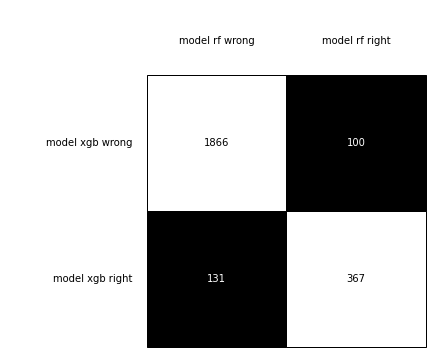

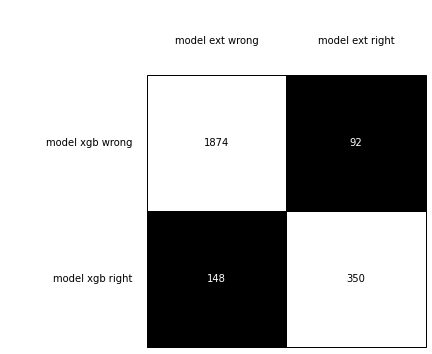

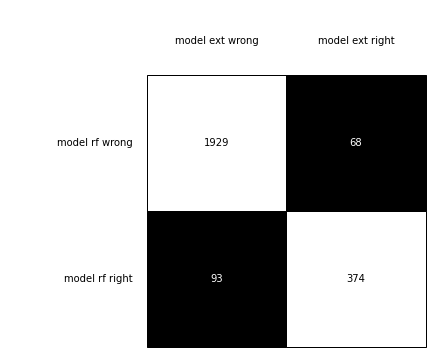

In [29]:
tb = mcnemar_tables(y_test_encoded, 
                    y_pred_xgbc,
                    y_pred_rfc, 
                    y_pred_et)

brd = checkerboard_plot(tb['model_0 vs model_1'],
                        figsize=(5, 5),
                        fmt='%d',
                        col_labels=['model rf wrong', 'model rf right'],
                        row_labels=['model xgb wrong', 'model xgb right'])
plt.show()

brd = checkerboard_plot(tb['model_0 vs model_2'],
                        figsize=(5, 5),
                        fmt='%d',
                        col_labels=['model ext wrong', 'model ext right'],
                        row_labels=['model xgb wrong', 'model xgb right'])
plt.show()

brd = checkerboard_plot(tb['model_1 vs model_2'],
                        figsize=(5, 5),
                        fmt='%d',
                        col_labels=['model ext wrong', 'model ext right'],
                        row_labels=['model rf wrong', 'model rf right'])
plt.show()

<hr>
<h2>Hyperparameters tunning</h2>
<hr>
<p>Let's start to tune the extratree's hyperparameters. because That algorithm had the better accuracy 82.02% and the better f1-socre: 79.14% </p>

In [30]:
#let's tunning Extratree Classifier
gkf = KFold(n_splits=3, shuffle=True, random_state=42).split(X=X_train, y=y_train_encoded)

# A parameter grid for XGBoost
params = {
    'n_estimators': range(100, 500, 100),
    'ccp_alpha': [0.0, 0.1],
    'criterion': ['gini'],
    'max_depth': [5,11],
    'min_samples_split': [2,3],
}

extree_estimator = ExtraTreesClassifier()

gsearch = GridSearchCV(
    estimator= extree_estimator,
    param_grid= params,
    scoring='f1_weighted',
    n_jobs=-1,
    cv=gkf,
    verbose=3,
)

extree_model = gsearch.fit(X=X_train, y=y_train_encoded)
(gsearch.best_params_, gsearch.best_score_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 2/3] END ccp_alpha=0.0, criterion=gini, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.652 total time=   1.4s
[CV 1/3] END ccp_alpha=0.0, criterion=gini, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.656 total time=   1.4s
[CV 3/3] END ccp_alpha=0.0, criterion=gini, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.670 total time=   1.6s
[CV 1/3] END ccp_alpha=0.0, criterion=gini, max_depth=5, min_samples_split=2, n_estimators=200;, score=0.649 total time=   3.2s
[CV 2/3] END ccp_alpha=0.0, criterion=gini, max_depth=5, min_samples_split=2, n_estimators=200;, score=0.667 total time=   3.0s
[CV 3/3] END ccp_alpha=0.0, criterion=gini, max_depth=5, min_samples_split=2, n_estimators=200;, score=0.663 total time=   3.0s
[CV 1/3] END ccp_alpha=0.0, criterion=gini, max_depth=5, min_samples_split=2, n_estimators=300;, score=0.648 total time=   4.1s
[CV 2/3] END ccp_alpha=0.0, criterion=gini,

({'ccp_alpha': 0.0,
  'criterion': 'gini',
  'max_depth': 11,
  'min_samples_split': 2,
  'n_estimators': 400},
 0.8374225485272748)

In [31]:
#and now I'm gonna tune with a higher random_state param ()
gkf_2 = KFold(n_splits=3, shuffle=True, random_state=84).split(X=X_train, y=y_train_encoded)

params_2 = {
    'n_estimators': range(400, 800, 100),
    'max_depth': [11,15],
    'min_samples_split': [2,3],
    'class_weight': ['balanced', None],

}

extree_2 = ExtraTreesClassifier(ccp_alpha = 0.0,
                                criterion = 'gini',
                                max_depth = 11,
                                min_samples_split = 3,
                                n_estimators = 400)

gsearch_2 = GridSearchCV(
    estimator= extree_2,
    param_grid= params_2,
    scoring='f1_weighted',
    n_jobs=-1,
    cv=gkf_2,
    verbose=3,
)

extree_model_2 = gsearch_2.fit(X=X_train, y=y_train_encoded)

(gsearch_2.best_params_, gsearch_2.best_score_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 1/3] END class_weight=balanced, max_depth=11, min_samples_split=2, n_estimators=400;, score=0.835 total time=  11.8s
[CV 2/3] END class_weight=balanced, max_depth=11, min_samples_split=2, n_estimators=400;, score=0.838 total time=  12.0s
[CV 3/3] END class_weight=balanced, max_depth=11, min_samples_split=2, n_estimators=400;, score=0.833 total time=  12.4s
[CV 1/3] END class_weight=balanced, max_depth=11, min_samples_split=2, n_estimators=500;, score=0.839 total time=  16.1s
[CV 2/3] END class_weight=balanced, max_depth=11, min_samples_split=2, n_estimators=500;, score=0.834 total time=  14.1s
[CV 3/3] END class_weight=balanced, max_depth=11, min_samples_split=2, n_estimators=500;, score=0.833 total time=  14.2s
[CV 1/3] END class_weight=balanced, max_depth=11, min_samples_split=2, n_estimators=600;, score=0.837 total time=  17.6s
[CV 2/3] END class_weight=balanced, max_depth=11, min_samples_split=2, n_estimators=600;, sc

({'class_weight': None,
  'max_depth': 15,
  'min_samples_split': 2,
  'n_estimators': 600},
 0.9083667559135317)

In [32]:
#run model with tunned parameters from the second tuned model
#({'class_weight': None,
#  'max_depth': 15,
#  'min_samples_split': 2,
#  'n_estimators': 700},
# 0.910189520538368)
extree_tuned = ExtraTreesClassifier(ccp_alpha = 0.0,
                                criterion = 'gini',
                                min_samples_split = 2,
                                class_weight = 'balanced',
                                max_depth = 15,
                                n_estimators = 700)

extree_tuned.fit(X_train, y_train_encoded)
y_pred_tuned = extree_tuned.predict(X_test)

<hr>
<h2>Saving the model</h2>
<hr>

In [35]:
joblib.dump(extree_tuned, '../models/RTA_model.joblib', compress=5)
pickle.dump(extree_tuned, open('../models/RTA_model.pkl', 'wb'))